# CVAE on generating flux vacua

## Import libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os
import numpy as np

## Define onehot function

In [2]:
def label_to_onehot(x, max_dim):
    """
    Convert a list of labels to one-hot encoded vectors for values in [0, max_dim - 1].
    
    Args:
        x: list of labels for the input images
        max_dim (int): number of possible classes (the size of onehot vector)
    """
    batch_size = x.shape[0] # number of samples in the batch
    vector = torch.zeros(batch_size, max_dim).to(x.device) # to(x.device) ensures the onehot vector tensor 
                                                           # is on the same device (CPU/GPU) as x
    for i in range(batch_size):
        vector[i,x[i]] = 1
    return vector

In [3]:
def coordinate_to_onehot(coord, max_dim=21):
    """
    Convert a coordinate vector to a concatenated one-hot encoded vector for values in [-10, 10].
    
    Args:
        coord (torch.Tensor): A vector of integers in the range [-10, 10].
        max_dim (int): The number of dimensions for one-hot encoding (default is 21 for range [-10, 10]).
    
    Returns:
        torch.Tensor: A single concatenated one-hot encoded vector.
    """
    onehot_vectors = []  # List to store one-hot vectors for each coordinate
    for value in coord:
        onehot = torch.zeros(max_dim)
        onehot[int(value) + 10] = 1  # Shift value by +10 to make index non-negative
        onehot_vectors.append(onehot)
    
    # Concatenate all one-hot vectors into a single vector
    concatenated_onehot = torch.cat(onehot_vectors, dim=0)
    return concatenated_onehot

In [4]:
coordinate_to_onehot(coord=[1,2,-10], max_dim=21)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model structure

In [5]:
class Encoder(torch.nn.Module):
    #encoder, compress data with input_size dimensions to mu and sigma with latent_size dimensions
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):
        x = F.relu(self.linear1(x)) 
        mu = self.mu(x) 
        sigma = self.sigma(x)
        return mu,sigma


class Decoder(nn.Module):
    def __init__(self, latent_size, hidden_size, num_logits, output_per_logit):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_logits * output_per_logit)
        self.num_logits = num_logits
        self.output_per_logit = output_per_logit

    def forward(self, x):
        x = F.relu(self.linear1(x))
        logits = self.linear2(x)
        # Dynamically split the logits
        logits = logits.view(-1, self.num_logits, self.output_per_logit)
        return logits.unbind(dim=1)  # Return as tuple of logits


class CVAE(nn.Module):
    def __init__(self, input_size, output_size, condition_size, latent_size, hidden_size, num_logits=8):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size + condition_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size + condition_size, hidden_size, num_logits, output_size // num_logits)
        
    def forward(self, x, c):
        x = torch.cat((x, c), dim=1)  # Concatenate input and condition
        mu, sigma = self.encoder(x)
        eps = torch.randn_like(sigma)  # Sample from standard normal
        z = mu + eps * sigma  # Reparameterization trick
        z = torch.cat((z, c), dim=1)  # Concatenate latent vector with condition
        # z = z + torch.normal(mean=0, std=0.1, size=z.size()).to(z.device)  # Add small noise
        logits = self.decoder(z)  # Dynamically unpack logits
        return logits, mu, sigma

## Loss function

In [6]:
loss_CE = nn.CrossEntropyLoss()
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

## Model parameters

In [7]:
latent_size = 128 # latent space dimension
hidden_size = 256 # hidden layer dimension
input_size = output_size = 21 * 8 # input_size for 8D coordinates 
condition_size = 3

## Training parameters

In [8]:
epochs = 30
batch_size = 128
learning_rate = 1e-3
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model construction

In [9]:
model = CVAE(input_size, output_size, condition_size, latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
try:
    model.load_state_dict(torch.load(modelname))
    print('[INFO] Load Model complete')
except:
    pass

## Prepare for dataset

In [10]:
def N_flux(coord):
    return coord[0]*coord[6] + coord[1]*coord[7] - coord[2]*coord[4] - coord[3]*coord[5]

In [11]:
import random

train_dataset = []
test_dataset = []

train_set_visualise = []
N_flux_data = []

for j in range(7000):
    f = torch.tensor([random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10)])
    h = torch.tensor([random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10)])
    coord = torch.cat((f, h))

    train_set_visualise.append(coord)
    
    N_flux_data.append(N_flux(coord))

    if -40 < N_flux(coord) < 40:
        label = 0
    elif N_flux(coord) <= -40:
        label = 1
    elif N_flux(coord) >= 40:
        label = 2

    onehot_coord = coordinate_to_onehot(coord)  # Convert to one-hot
    data_point = (onehot_coord, label)  # Store one-hot encoded vector with label
    train_dataset.append(data_point)


for j in range(1500):
    f = torch.tensor([random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10)])
    h = torch.tensor([random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10), random.randint(-10, 10)])
    coord = torch.cat((f, h))

    if -40 < N_flux(coord) < 40:
        label = 0
    elif N_flux(coord) <= -40:
        label = 1
    elif N_flux(coord) >= 40:
        label = 2

    onehot_coord = coordinate_to_onehot(coord)  # Convert to one-hot
    data_point = (onehot_coord, label)  # Store one-hot encoded vector with label
    test_dataset.append(data_point)

In [12]:
# check some data
n = 313
coord = train_set_visualise[n]
coord1 = train_dataset[n]
print(coord)
print(N_flux(coord))
print(coord1)

tensor([ 6,  4, 10, -9,  3, -8, -3, 10])
tensor(-80)
(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.]), 1)


7000


Text(0, 0.5, 'Frequency')

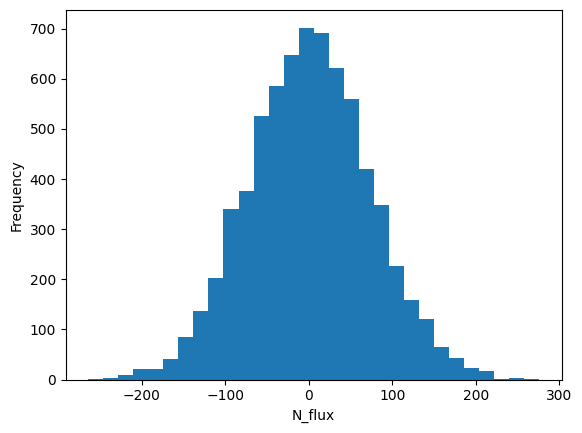

In [13]:
# visualise training dataset
print(len(N_flux_data))
plt.hist(list(N_flux_data), bins=30)
plt.xlabel("N_flux")
plt.ylabel("Frequency")

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model training

In [15]:
# Define the classifier to regularize the latent space
class Classifier(nn.Module):
    def __init__(self, latent_size, num_labels):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(latent_size, num_labels)

    def forward(self, x):
        return self.fc(x)

# Create classifier instance
classifier = Classifier(latent_size, num_labels=3)
classifier.to(device)



def cluster_loss(latent_space, labels):
    """
    Penalizes clusters in the latent space that are too close to each other.
    Args:
        latent_space (torch.Tensor): Latent space vectors (batch_size, latent_size).
        labels (torch.Tensor): Integer labels (batch_size).
    Returns:
        torch.Tensor: The cluster loss value.
    """
    unique_labels = torch.unique(labels)
    cluster_centers = []
    for label in unique_labels:
        cluster_points = latent_space[labels == label]
        cluster_centers.append(cluster_points.mean(dim=0))
    cluster_centers = torch.stack(cluster_centers)
    pairwise_distances = torch.cdist(cluster_centers, cluster_centers)
    return torch.sum(torch.exp(-pairwise_distances))  # Penalize clusters that are too close



def flux_loss(coords, labels):
    """
    Penalizes data points with label 1 and 2 that are away 
    from the respective center values which are set manually.
    """
    # Convert flux values to a tensor
    flux_values = torch.tensor([N_flux(coord) for coord in coords], dtype=torch.float32)
    
    # Create flux targets with zeros_like
    flux_targets = torch.zeros_like(flux_values)
    
    # Assign target values based on labels
    flux_targets[labels == 1] = -60  # Center value for label 1
    flux_targets[labels == 2] = 60   # Center value for label 2
    
    # Compute the mean squared error loss
    return torch.mean((flux_values - flux_targets) ** 2)




# Training loop
modelname = 'cvae_pytorch_flux_vacua3.pth'

for epoch in range(epochs):   
    '''Model Training'''
    train_loss = 0  # Reset loss for each epoch

    for imgs, lbls in tqdm(train_loader, desc=f'[train] epoch: {epoch}'):
        bs = imgs.shape[0]
        imgs = imgs.view(bs, input_size).to(device)
        lbls_onehot = label_to_onehot(lbls.to(device), condition_size)

        # Forward pass
        logits, mu, sigma = model(imgs, lbls_onehot)  # logits is a tuple of 8 logits
        
        # Calculate targets dynamically
        targets = [imgs[:, i * 21:(i + 1) * 21].argmax(dim=1) for i in range(8)]

        # Calculate categorical cross-entropy losses
        loss_re = sum(loss_CE(logit, target) for logit, target in zip(logits, targets))

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)

        # Auxiliary classification loss
        latent_space = mu  # Use the latent representation from the encoder (mu)
        label_logits = classifier(latent_space)  # Pass the latent space through the classifier
        class_weights = torch.tensor([1.0, 3.0, 3.0]).to(device)  # Increase weight for labels 1 and 2
        classification_loss = nn.CrossEntropyLoss(weight=class_weights)(label_logits, lbls)


        # Cluster loss
        cluster_loss_value = cluster_loss(latent_space, lbls)

        # Compute flux loss
        # Decode logits to reconstruct flux coordinates
        reconstructed_coords = []
        for logit in logits:
            coord_indices = logit.argmax(dim=1).cpu() - 10  # Map indices back to [-10, 10]
            reconstructed_coords.append(coord_indices)
        reconstructed_coords = torch.stack(reconstructed_coords, dim=1)  # Stack into tensor (batch_size, 8)
        flux_loss_value = flux_loss(reconstructed_coords, lbls) / 300  # Compute flux loss


        # Combine the losses 
        beta = 0.5
        alpha = 1
        gamma = 2  # Weight for the cluster loss term
        delta = 5  # Weight for flux loss
        loss = loss_re + beta * loss_norm + alpha * classification_loss + gamma * cluster_loss_value + delta * flux_loss_value

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Record total loss
        train_loss += loss.item()

    # Print average loss
    print(f'epoch: {epoch} | Train Loss: {train_loss / len(train_loader.dataset):.4f}')

    # Evaluate the model
    model.eval()
    test_loss = 0
    for imgs, lbls in tqdm(test_loader, desc=f'[eval] epoch: {epoch}'):
        bs = imgs.shape[0]
        imgs = imgs.view(bs, input_size).to(device)
        lbls_onehot = label_to_onehot(lbls.to(device), condition_size)

        # Forward pass
        logits, mu, sigma = model(imgs, lbls_onehot)

        # Calculate targets dynamically
        targets = [imgs[:, i * 21:(i + 1) * 21].argmax(dim=1) for i in range(8)]

        # Calculate categorical cross-entropy losses
        loss_re = sum(loss_CE(logit, target) for logit, target in zip(logits, targets))

        # KLD regularization
        loss_norm = loss_KLD(mu, sigma)

        # Auxiliary classification loss
        latent_space = mu
        label_logits = classifier(latent_space)
        class_weights = torch.tensor([1.0, 3.0, 3.0]).to(device)  # Increase weight for labels 1 and 2
        classification_loss = nn.CrossEntropyLoss(weight=class_weights)(label_logits, lbls)

        # Cluster loss
        cluster_loss_value = cluster_loss(latent_space, lbls)

        # Compute flux loss
        # Decode logits to reconstruct flux coordinates
        reconstructed_coords = []
        for logit in logits:
            coord_indices = logit.argmax(dim=1).cpu() - 10  # Map indices back to [-10, 10]
            reconstructed_coords.append(coord_indices)
        reconstructed_coords = torch.stack(reconstructed_coords, dim=1)  # Stack into tensor (batch_size, 8)
        flux_loss_value = flux_loss(reconstructed_coords, lbls) / 300  # Compute flux loss


        # Combine the losses
        beta = 0.5
        alpha = 1
        gamma = 2  # Weight for the cluster loss term
        delta = 5  # Weight for flux loss
        loss = loss_re + beta * loss_norm + alpha * classification_loss + gamma * cluster_loss_value + delta * flux_loss_value

        # Record total loss
        test_loss += loss.item()

    # Print test loss
    print(f'epoch: {epoch} | Test Loss: {test_loss / len(test_loader.dataset):.4f}')
    model.train()

    print(f"Mu Mean: {mu.mean().item()}, Mu Std: {mu.std().item()}")

# Save the model
torch.save(model.state_dict(), modelname)
print(f"{modelname} is saved")


[train] epoch: 0: 100%|██████████| 55/55 [00:00<00:00, 119.30it/s]


epoch: 0 | Train Loss: 99.9016


[eval] epoch: 0: 100%|██████████| 12/12 [00:00<00:00, 166.43it/s]


epoch: 0 | Test Loss: 56.7268
Mu Mean: 0.00013916168245486915, Mu Std: 0.03232021629810333


[train] epoch: 1: 100%|██████████| 55/55 [00:00<00:00, 128.00it/s]


epoch: 1 | Train Loss: 40.0482


[eval] epoch: 1: 100%|██████████| 12/12 [00:00<00:00, 169.65it/s]


epoch: 1 | Test Loss: 27.8545
Mu Mean: -0.00028941690106876194, Mu Std: 0.025686925277113914


[train] epoch: 2: 100%|██████████| 55/55 [00:00<00:00, 129.37it/s]


epoch: 2 | Train Loss: 20.9920


[eval] epoch: 2: 100%|██████████| 12/12 [00:00<00:00, 164.82it/s]


epoch: 2 | Test Loss: 15.7148
Mu Mean: -0.0002357785269850865, Mu Std: 0.023158852010965347


[train] epoch: 3: 100%|██████████| 55/55 [00:00<00:00, 128.36it/s]


epoch: 3 | Train Loss: 12.6779


[eval] epoch: 3: 100%|██████████| 12/12 [00:00<00:00, 167.21it/s]


epoch: 3 | Test Loss: 9.9600
Mu Mean: 0.000603367923758924, Mu Std: 0.0222723837941885


[train] epoch: 4: 100%|██████████| 55/55 [00:00<00:00, 127.05it/s]


epoch: 4 | Train Loss: 8.4128


[eval] epoch: 4: 100%|██████████| 12/12 [00:00<00:00, 169.17it/s]


epoch: 4 | Test Loss: 6.9247
Mu Mean: 8.781946962699294e-05, Mu Std: 0.02121971733868122


[train] epoch: 5: 100%|██████████| 55/55 [00:00<00:00, 127.08it/s]


epoch: 5 | Train Loss: 6.0808


[eval] epoch: 5: 100%|██████████| 12/12 [00:00<00:00, 168.75it/s]


epoch: 5 | Test Loss: 5.2793
Mu Mean: 0.0005154116661287844, Mu Std: 0.0216052383184433


[train] epoch: 6: 100%|██████████| 55/55 [00:00<00:00, 128.66it/s]


epoch: 6 | Train Loss: 4.6977


[eval] epoch: 6: 100%|██████████| 12/12 [00:00<00:00, 94.21it/s]


epoch: 6 | Test Loss: 3.7216
Mu Mean: 0.0003558117605280131, Mu Std: 0.02149893343448639


[train] epoch: 7: 100%|██████████| 55/55 [00:00<00:00, 127.28it/s]


epoch: 7 | Train Loss: 3.4301


[eval] epoch: 7: 100%|██████████| 12/12 [00:00<00:00, 167.62it/s]


epoch: 7 | Test Loss: 3.1197
Mu Mean: -0.0004045402747578919, Mu Std: 0.020801832899451256


[train] epoch: 8: 100%|██████████| 55/55 [00:00<00:00, 121.57it/s]


epoch: 8 | Train Loss: 3.0269


[eval] epoch: 8: 100%|██████████| 12/12 [00:00<00:00, 152.94it/s]


epoch: 8 | Test Loss: 3.0637
Mu Mean: 0.0003667673736345023, Mu Std: 0.020860377699136734


[train] epoch: 9: 100%|██████████| 55/55 [00:00<00:00, 112.60it/s]


epoch: 9 | Train Loss: 2.8569


[eval] epoch: 9: 100%|██████████| 12/12 [00:00<00:00, 150.96it/s]


epoch: 9 | Test Loss: 2.5624
Mu Mean: -0.00047412142157554626, Mu Std: 0.021099023520946503


[train] epoch: 10: 100%|██████████| 55/55 [00:00<00:00, 119.46it/s]


epoch: 10 | Train Loss: 2.6001


[eval] epoch: 10: 100%|██████████| 12/12 [00:00<00:00, 154.79it/s]


epoch: 10 | Test Loss: 2.5957
Mu Mean: 0.00032854429446160793, Mu Std: 0.021040024235844612


[train] epoch: 11: 100%|██████████| 55/55 [00:00<00:00, 115.77it/s]


epoch: 11 | Train Loss: 2.5583


[eval] epoch: 11: 100%|██████████| 12/12 [00:00<00:00, 157.52it/s]


epoch: 11 | Test Loss: 2.2955
Mu Mean: -0.00025737116811797023, Mu Std: 0.020932821556925774


[train] epoch: 12: 100%|██████████| 55/55 [00:00<00:00, 119.13it/s]


epoch: 12 | Train Loss: 2.4383


[eval] epoch: 12: 100%|██████████| 12/12 [00:00<00:00, 148.11it/s]


epoch: 12 | Test Loss: 2.3581
Mu Mean: -0.000499071495141834, Mu Std: 0.020966889336705208


[train] epoch: 13: 100%|██████████| 55/55 [00:00<00:00, 115.06it/s]


epoch: 13 | Train Loss: 2.4243


[eval] epoch: 13: 100%|██████████| 12/12 [00:00<00:00, 149.84it/s]


epoch: 13 | Test Loss: 2.3672
Mu Mean: -0.0002925991720985621, Mu Std: 0.02071155607700348


[train] epoch: 14: 100%|██████████| 55/55 [00:00<00:00, 116.38it/s]


epoch: 14 | Train Loss: 2.4819


[eval] epoch: 14: 100%|██████████| 12/12 [00:00<00:00, 156.00it/s]


epoch: 14 | Test Loss: 2.4221
Mu Mean: -0.00017263276095036417, Mu Std: 0.020660849288105965


[train] epoch: 15: 100%|██████████| 55/55 [00:00<00:00, 114.53it/s]


epoch: 15 | Train Loss: 2.3517


[eval] epoch: 15: 100%|██████████| 12/12 [00:00<00:00, 146.76it/s]


epoch: 15 | Test Loss: 2.2680
Mu Mean: -0.00023369098198600113, Mu Std: 0.020775234326720238


[train] epoch: 16: 100%|██████████| 55/55 [00:00<00:00, 98.68it/s] 


epoch: 16 | Train Loss: 2.2238


[eval] epoch: 16: 100%|██████████| 12/12 [00:00<00:00, 148.76it/s]


epoch: 16 | Test Loss: 2.4439
Mu Mean: -0.0002312153810635209, Mu Std: 0.021874863654375076


[train] epoch: 17: 100%|██████████| 55/55 [00:00<00:00, 116.30it/s]


epoch: 17 | Train Loss: 2.3194


[eval] epoch: 17: 100%|██████████| 12/12 [00:00<00:00, 146.63it/s]


epoch: 17 | Test Loss: 2.3836
Mu Mean: 0.00010851216211449355, Mu Std: 0.02055145986378193


[train] epoch: 18: 100%|██████████| 55/55 [00:00<00:00, 118.50it/s]


epoch: 18 | Train Loss: 2.2808


[eval] epoch: 18: 100%|██████████| 12/12 [00:00<00:00, 146.88it/s]


epoch: 18 | Test Loss: 2.3137
Mu Mean: 3.884751276928e-05, Mu Std: 0.020460989326238632


[train] epoch: 19: 100%|██████████| 55/55 [00:00<00:00, 120.89it/s]


epoch: 19 | Train Loss: 2.2817


[eval] epoch: 19: 100%|██████████| 12/12 [00:00<00:00, 147.67it/s]


epoch: 19 | Test Loss: 2.3167
Mu Mean: 0.00042384539847262204, Mu Std: 0.020963424816727638


[train] epoch: 20: 100%|██████████| 55/55 [00:00<00:00, 116.96it/s]


epoch: 20 | Train Loss: 2.2135


[eval] epoch: 20: 100%|██████████| 12/12 [00:00<00:00, 169.72it/s]


epoch: 20 | Test Loss: 2.2701
Mu Mean: 6.903417670400813e-05, Mu Std: 0.020422127097845078


[train] epoch: 21: 100%|██████████| 55/55 [00:00<00:00, 120.61it/s]


epoch: 21 | Train Loss: 2.2579


[eval] epoch: 21: 100%|██████████| 12/12 [00:00<00:00, 149.65it/s]


epoch: 21 | Test Loss: 2.3783
Mu Mean: -0.0001407417730661109, Mu Std: 0.02104027383029461


[train] epoch: 22: 100%|██████████| 55/55 [00:00<00:00, 116.44it/s]


epoch: 22 | Train Loss: 2.2055


[eval] epoch: 22: 100%|██████████| 12/12 [00:00<00:00, 150.34it/s]


epoch: 22 | Test Loss: 2.2939
Mu Mean: -0.00023525698634330183, Mu Std: 0.02056630700826645


[train] epoch: 23: 100%|██████████| 55/55 [00:00<00:00, 121.45it/s]


epoch: 23 | Train Loss: 2.1874


[eval] epoch: 23: 100%|██████████| 12/12 [00:00<00:00, 155.71it/s]


epoch: 23 | Test Loss: 2.0703
Mu Mean: -0.00025973431183956563, Mu Std: 0.021458938717842102


[train] epoch: 24: 100%|██████████| 55/55 [00:00<00:00, 119.33it/s]


epoch: 24 | Train Loss: 2.0579


[eval] epoch: 24: 100%|██████████| 12/12 [00:00<00:00, 147.42it/s]


epoch: 24 | Test Loss: 2.2402
Mu Mean: -0.00031899570603854954, Mu Std: 0.02064482308924198


[train] epoch: 25: 100%|██████████| 55/55 [00:00<00:00, 115.86it/s]


epoch: 25 | Train Loss: 2.1583


[eval] epoch: 25: 100%|██████████| 12/12 [00:00<00:00, 88.41it/s]


epoch: 25 | Test Loss: 2.0452
Mu Mean: 0.000490764097776264, Mu Std: 0.020708534866571426


[train] epoch: 26: 100%|██████████| 55/55 [00:00<00:00, 108.00it/s]


epoch: 26 | Train Loss: 2.0792


[eval] epoch: 26: 100%|██████████| 12/12 [00:00<00:00, 150.88it/s]


epoch: 26 | Test Loss: 2.0241
Mu Mean: -0.00032399495830759406, Mu Std: 0.020478008314967155


[train] epoch: 27: 100%|██████████| 55/55 [00:00<00:00, 119.58it/s]


epoch: 27 | Train Loss: 2.0660


[eval] epoch: 27: 100%|██████████| 12/12 [00:00<00:00, 150.09it/s]


epoch: 27 | Test Loss: 2.0987
Mu Mean: 0.0002936625969596207, Mu Std: 0.02081560716032982


[train] epoch: 28: 100%|██████████| 55/55 [00:00<00:00, 121.22it/s]


epoch: 28 | Train Loss: 2.1090


[eval] epoch: 28: 100%|██████████| 12/12 [00:00<00:00, 152.12it/s]


epoch: 28 | Test Loss: 2.0498
Mu Mean: -0.0003975100116804242, Mu Std: 0.021085144951939583


[train] epoch: 29: 100%|██████████| 55/55 [00:00<00:00, 118.88it/s]


epoch: 29 | Train Loss: 2.0411


[eval] epoch: 29: 100%|██████████| 12/12 [00:00<00:00, 155.46it/s]

epoch: 29 | Test Loss: 2.1144
Mu Mean: -0.00038700891309417784, Mu Std: 0.021160978823900223
cvae_pytorch_flux_vacua3.pth is saved


## Latent space plotting

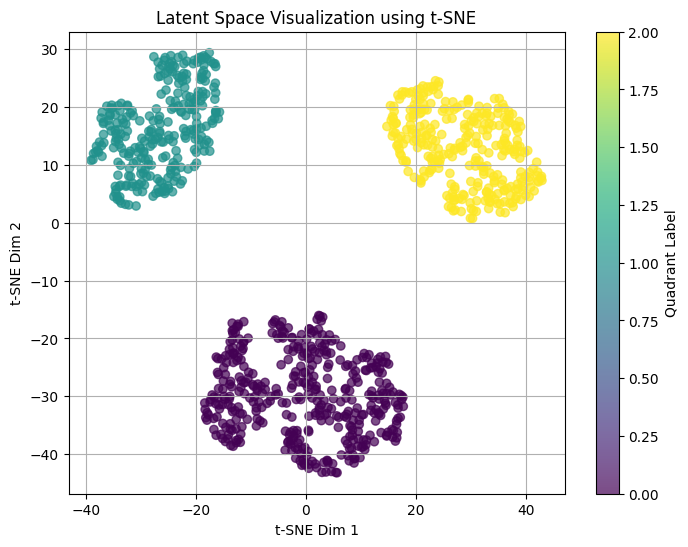

In [16]:
import sklearn
from sklearn.manifold import TSNE

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_vectors = []
    labels = []

    # Collect latent vectors for a subset of samples
    with torch.no_grad():
        for imgs, lbls in data_loader:
            imgs = imgs.to(device)
            lbls = label_to_onehot(lbls.to(device), condition_size)
            
            # Get the latent vectors
            mu, _ = model.encoder(torch.cat((imgs, lbls), dim=1))
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(lbls.cpu().numpy())

            if len(latent_vectors) >= num_samples:
                break

    # Convert to numpy array
    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels)[:num_samples]

    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot the 2D latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels.argmax(axis=1), cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label="Quadrant Label")
    plt.title("Latent Space Visualization using t-SNE")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()

# Use this function after training the model
plot_latent_space(model, train_loader)

## Visualisation

In [17]:
'''Model prediction''' # use trained model or saved trained model to predict

def generate_sample(i):
    '''
        generate a sample from the latent space with label i
        i: the quadrant index, ranging from 0 to 2
    '''

    sample = torch.randn(1, latent_size).to(device)

    # # sample near the mean instead
    # condition = label_to_onehot(torch.tensor([i]), condition_size)  # One-hot encode the target class
    # z_mean, _ = model.encoder(torch.cat((torch.zeros(1, input_size), condition), dim=1).to(device))
    # epsilon = 0.6
    # sample = z_mean + epsilon * torch.randn_like(z_mean)  # Add small noise for diversity


    i_number = i * torch.ones(1).long().to(device) 
    condit = label_to_onehot(i_number, condition_size)  # One-hot encoding of the label
    inputs = torch.cat((sample, condit), dim=1)  # Concatenate latent sample and condition

    # Decode logits
    with torch.no_grad():
        logits = model.decoder(inputs)  # Decode to obtain logits as a tuple

    # Compute predicted coordinates
    predicted_coord = [logit.argmax(dim=1).item() - 10 for logit in logits]

    return predicted_coord

coord = generate_sample(i=2)
print(f"Generated flux: {coord}")
print(N_flux(coord))

Generated flux: [8, -2, 9, 9, -7, -10, 7, -5]
219


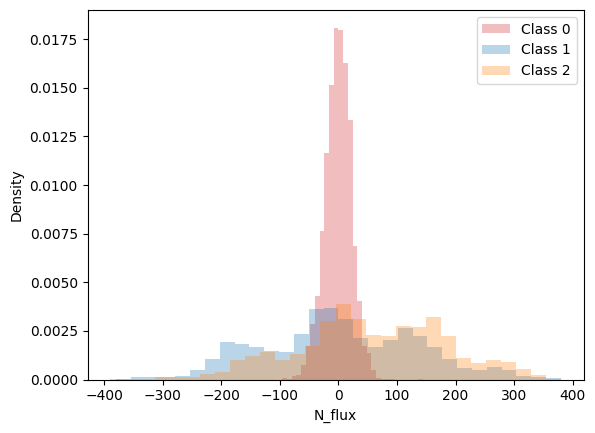

In [19]:
plt.hist(np.array([N_flux(generate_sample(i=0)) for i in range(5000)]), bins=30, alpha=0.3, color='tab:red', label='Class 0', density=True)
plt.hist(np.array([N_flux(generate_sample(i=1)) for i in range(5000)]), bins=30, alpha=0.3, color='tab:blue', label='Class 1', density=True)
plt.hist(np.array([N_flux(generate_sample(i=2)) for i in range(5000)]), bins=30, alpha=0.3, color='tab:orange', label='Class 2', density=True)
plt.legend()
plt.xlabel("N_flux")
plt.ylabel("Density")
plt.show()